# Click-Through Rate Prediction

> In online advertising, click-through rate (CTR) is a very important metric for evaluating ad performance. As a result, click prediction systems are essential and widely used for sponsored search and real-time bidding.
>
> [Competition page](https://www.kaggle.com/c/avazu-ctr-prediction)

## Libraries

 * **Numpy:** Useful for algebra and other mathematical utilities
 * **Pandas:** Library that enables working with dataframes
 * **Dask:** Provides functionality that mimics numpy arrays and pandas dataframes, while performing out-of-core computations
 * **Matplotlib:** Useful for fast and non-interactive visualizations
 * **Plotly:** Visualization library, with a lot of interactive functionality
 * **Sci-kit Learn:** Library with machine learning algorithms, useful, e.g., for exploratory and predictive data analysis

Start by clearing variables from previous runs 

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


In [110]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sklearn

Set Matplotly and Plotly to be used inline throughou the notebook:

In [3]:
# Matplotlib
%matplotlib inline

# Pyplot
init_notebook_mode(connected=True)

Beautify Matplotlib:

In [4]:
matplotlib.style.use('ggplot')

Import the dataset using Pandas dataframes, with proper configuration:

In [5]:
date_parser = lambda x: pd.datetime.strptime(x, '%y%m%d%H')

These are the datatypes for the data features. These were obtained through a previous observation of the data contents, and in the case of integers, of the integers feature ranges.

In [6]:
data_types = {
    'id': np.str,
    'click': np.bool_,
    'hour': np.str,
    'C1': np.uint16,
    'banner_pos': np.uint16,
    'site_id': np.object,
    'site_domain': np.object,
    'site_category': np.object,
    'app_id': np.object,
    'app_domain': np.object,
    'app_category': np.object,
    'device_id': np.object,
    'device_ip': np.object,
    'device_model': np.object,
    'device_type': np.uint16,
    'device_conn_type': np.uint16,
    'C14': np.uint16,
    'C15': np.uint16,
    'C16': np.uint16,
    'C17': np.uint16,
    'C18': np.uint16,
    'C19': np.uint16,
    'C20': np.uint16,
    'C21': np.uint16    
}

Now we have to load the training dataset. It is already ordered chronologically. 
Functionality that can be reused will be enclosed into functions, and transformations to dataframes will be performed inplace, to preserve memory.

In [32]:
def load_train_data():
    train_df = pd.read_csv('./data/train/train.csv',
                           dtype=data_types,
                           parse_dates=['hour'],
                           date_parser=date_parser)
    return train_df

In [7]:
%%time
train_df = load_train_data()

Wall time: 11min 25s


Extract some basic information about the data

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 24 columns):
id                  object
click               bool
hour                datetime64[ns]
C1                  uint16
banner_pos          uint16
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type         uint16
device_conn_type    uint16
C14                 uint16
C15                 uint16
C16                 uint16
C17                 uint16
C18                 uint16
C19                 uint16
C20                 uint16
C21                 uint16
dtypes: bool(1), datetime64[ns](1), object(10), uint16(12)
memory usage: 260.8+ MB


We have a little more than 40 million examples to work with, 
It is possible to see that, through data type specification, we are able to reduce the data memory footprint to 260.8 MB. (This could be lowered even more by taking the object data types, and substitute by integers that keep the same identity.)

Now we can visualize some examples:

In [10]:
train_df.iloc[:, :12].head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id
0,1000009418151094273,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a
1,10000169349117863715,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a
2,10000371904215119486,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a
3,10000640724480838376,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a
4,10000679056417042096,False,2014-10-21,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a


In [11]:
train_df.iloc[:, 12:].head()

,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,65535,79
1,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,34548,79
2,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,34548,79
3,e8275b8f,6332421a,1,0,15706,320,50,1722,0,35,34548,79
4,9644d0bf,779d90c2,1,0,18993,320,50,2161,0,35,65535,157


The target for the prediction task is the 'click' column. We have a mixture of time-based and categorical features available, that will be explored next.

## Exploratory Data Analysis and Feature Engineering

This section seeks to explore each feature we have available, as well as relationships between them and the target variable. The objective here is to gain some intuition over the data, whether it is, e.g., through statistics or visualizations. Provided with this knowledge, new features may be derived, that will (hopefully) help our prediction task down the road.

### *id*
This feature raises the question if it is unique accross the dataset. If that is true, it does not provide any information that may be interesting for our task, as no two examples may be compared through it.

In [36]:
train_df.shape[0] == train_df['id'].unique().shape[0]

True

As that is true, it can be removed this column from the dataframe:

In [37]:
def remove_id_col(df):
    df.drop('id', axis=1, inplace=True)
    return df

In [38]:
train_df = remove_id_col(train_df)

### *click*
This is the target variable. It is useful to know how it is distributed throghout the data:

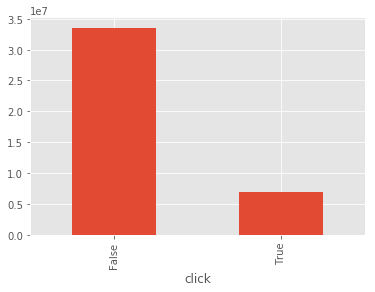

In [41]:
train_df.groupby('click').size().plot(kind='bar')

In [31]:
train_df['click'].value_counts() / train_df.shape[0]

False    0.830194
True     0.169806
Name: click, dtype: float64

The label more represented in the dataset is for no-clicks in ads (which was expected from a real-world dataset), which accounts for arround 83% of the data.
The fact that we are dealing with an unballanced dataset should be taken into account down the road, by using stratified sampling in separating the training and test datasets, using stratified k-fold cross-validation, resample examples to balance the dataset, and, when applicable, provide hyperparameters to the classifiers that changes how they weight each example.

###  *hour*
Each event has associated a timestamp, with precision up to the hour.
Lets start by determining the datetime range

In [155]:
train_df.hour.describe()

count                40428967
unique                    240
top       2014-10-22 09:00:00
freq                   447783
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

The dataset starts on a Tuesday, and ends on a Thursday (test data corresponds to a Friday then).

Time features are naturally thought about in terms of cycles: day-night, hours of the day, day of the week, etc. Lets then derive the features: day of the week and hour of day, which may be the ones that vary enough in the dataset small time-frame to capture interesting patterns, as well as a feature that is essentially a convertion from hours to integers (grow as the hour grows). The function also return the hour it used to start the hours counter (useful when deriving features in the test dataset).

In [149]:
def derive_time_features(df, start_hour=None, remove_original_feature=False):
    if start_hour is None:
        start_hour = df['hour'][0]
        
    df['hour_int'] = train_df['hour'].apply(lambda x: (x - start_hour) / np.timedelta64(1, 'h'))
    df['day_week'] = train_df['hour'].apply(lambda x: x.dayofweek)
    df['hour_day'] = train_df['hour'].apply(lambda x: x.hour)
    
    if remove_original_feature:
        df.drop('hour', axis=1, inplace=True)
    
    return df, start_hour

In [150]:
train_df, _ = derive_time_features(train_df)

Now lets visualize those derived features:

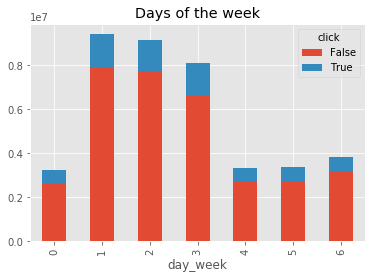

In [151]:
train_df.groupby(['day_week', 'click']).size().unstack().plot(kind='bar', stacked=True, title='Days of the week')

**NOTE:** Monday=0, Sunday = 6

The spikes we found here correspond to the days of the week for which we have two-days worth of data.

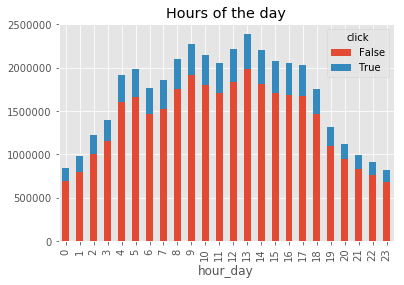

In [153]:
train_df.groupby(['hour_day', 'click']).size().unstack().plot(kind='bar', stacked=True, title='Hours of the day')

Clicks seem to follow the general traffic to websites.

### *banner_pos*

The banner position seem to be intuitively (paired with good design and envolving design) one of the good predictors for an ad CTR. Before further conclusions, the data format should be analysed:

In [165]:
train_df['banner_pos'].unique()

array([0, 1, 4, 5, 2, 7, 3], dtype=int64)

The *banner_pos* comes as an option among 7 integers, and it is not obvious of what it represents. We should not assume that is ordering has any meaning (it may very well be that each integer corresponds to a broad 2D position in a webpage). Lets see how it relates to clicks:

In [167]:
train_banner_pos_group_df = train_df.groupby(['banner_pos', 'click']).size().unstack()

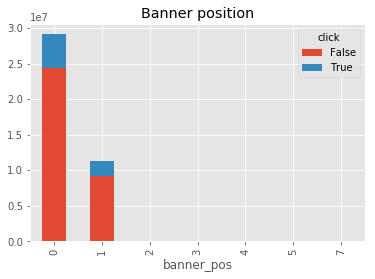

In [168]:
train_banner_pos_group_df.plot(kind='bar', stacked=True, title='Banner position')

Positions 0 and 1 seem to be the most used ones. We have to make another plot to gain insight over the other variables:

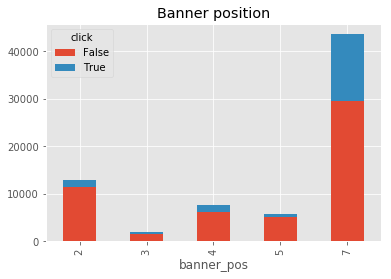

In [178]:
train_banner_pos_group_df.iloc[2:].plot(kind='bar', stacked=True, title='Banner position')

Position 7 seems to be very good for positioning ads.
These are the normalized properties:

In [185]:
train_banner_pos_group_df / train_df.shape[0]

click,False,True
banner_pos,,
0,0.601739,0.118279
1,0.227117,0.051081
2,0.000283,0.000038
3,0.000041,0.000009
4,0.000155,0.000035
5,0.000126,0.000017
7,0.000733,0.000345


Now normalized by banner position:

In [188]:
train_banner_pos_group_df.div(train_banner_pos_group_df.sum(axis=1), axis=0)

click,False,True
banner_pos,,
0,0.835728,0.164272
1,0.816386,0.183614
2,0.880778,0.119222
3,0.817199,0.182801
4,0.814642,0.185358
5,0.878505,0.121495
7,0.679900,0.320100


Effectively, the CTR for position 7 is slightly above 32%. Positions 0, 1, 3 and 4 seem to be close contenders, with almost 20%.